In [1]:
from pathlib import Path
import pandas as pd

result = list(Path("../llms-eval/NLI/").rglob("*.csv"))
result = [str(x) for x in result]
result

['../llms-eval/NLI/crowd/revised_premise/eval.csv',
 '../llms-eval/NLI/crowd/revised_hypothesis/eval.csv',
 '../llms-eval/NLI/crowd_wrong/revised_premise/eval.csv',
 '../llms-eval/NLI/crowd_wrong/revised_hypothesis/eval.csv']

In [2]:
df = pd.read_csv(result[-4])
df = df.dropna()
df = df[df['flip_label'] != '[]']
           
df

,Unnamed: 0,original_sentence1,original_sentence2,original label,contrast label,contrast text,flip_label,minimal_change_1,minimal_change_2,distribution
0,0,A man with a beard is talking on the cellphone...,A man is prone on the street while another man...,entailment,contradiction,A man with a beard is talking on the cellphone...,3.0,3.0,4.0,4.0
1,1,A man with a beard is talking on the cellphone...,A man is prone on the street while another man...,entailment,neutral,A man with a beard is talking on the cellphone...,3.0,3.0,2.0,3.0
2,2,A kid slides down a yellow slide into a swimmi...,The child slides into the pool.,entailment,contradiction,A kid slides down a yellow slide onto the ground.,4.0,3.0,2.0,3.0
3,3,A kid slides down a yellow slide into a swimmi...,The child slides into the pool.,entailment,neutral,A kid slides down a yellow slide.,3.0,3.0,2.0,3.0
4,4,A woman talks on a cellphone while sitting in ...,She has a conversation on her phone outdoors,entailment,contradiction,A woman talks on a cellphone while sitting in ...,4.0,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...
795,795,"A man wearing black pants, an orange and brown...",The bandana is expensive.,contradiction,entailment,"A man wearing black pants, an orange and brown...",4.0,3.0,3.0,3.0
796,796,At least eight people are sitting at a table i...,People sitting on the floor,contradiction,neutral,At least eight tall people are sitting at a ta...,3.0,3.0,3.0,3.0
797,797,At least eight people are sitting at a table i...,People sitting on the floor,contradiction,entailment,At least eight people are sitting at a table i...,3.0,2.0,2.0,3.0
798,798,A photographer and assistant take a photo of a...,The photographer is taking a photo of a dog.,contradiction,entailment,A photographer and assistant take a photo of t...,4.0,4.0,3.0,3.0


In [3]:
for i, row in df.iterrows():
    assert (int(row['flip_label']) <= 4)
    assert (int(row['flip_label']) >= 1)

    if int(row['flip_label']) < 1 or int(row['flip_label']) > 4:
        print(i) 

In [4]:
df['flip_label'].value_counts(normalize=True)

4.0    0.575188
3.0    0.418546
2.0    0.005013
1.0    0.001253
Name: flip_label, dtype: float64

In [5]:
def get_result(files): 
    #metrics = ['flip_label', 'minimal_change_1', 'minimal_change_2', 'distribution']#, 'grammar', 'cohesive', 'likability']
    metrics = ['flip_label']#, 'minimal_change_1', 'minimal_change_2', 'distribution']#, 'grammar', 'cohesive', 'likability']

    modes = ['mean']#, 'max', 'min']
    dict = {
        'LLM' : [], 
        'part': []
    }

    for m in metrics:
        for mode in modes:
            dict[m + ' - ' + mode] = []


    for f in files:
        llm_name = f.split('/')[-3]
        part =  f.split('/')[-2]


        if 'crowd' not in f:
            continue
    



        dict['LLM'].append(llm_name)
        dict['part'].append(part)

    

        for m in metrics:
            df = pd.read_csv(f)
            df = df.dropna()
            df = df[df['flip_label'] != '[]']
            if m not in df.columns:
                continue

            df[m] = pd.to_numeric(df[m])



            #if m != 'flip_label':
            #    df = df[df['flip_label'] < 3.0]

            for mode in modes:
                if mode == 'mean':
                    dict[m + ' - ' + mode].append(df[m].mean().round(2))
                if mode == 'max':
                    dict[m + ' - ' + mode].append(df[m].max().round(2))
                if mode == 'min':
                    dict[m + ' - ' + mode].append(df[m].min().round(2))

    df_results = pd.DataFrame.from_dict(dict)
    return df_results.sort_values(by=['part', 'LLM'])

In [6]:
mean_results = get_result(result)
mean_results.columns

Index(['LLM', 'part', 'flip_label - mean'], dtype='object')

In [7]:
mean_results

,LLM,part,flip_label - mean
1,crowd,revised_hypothesis,3.56
3,crowd_wrong,revised_hypothesis,1.72
0,crowd,revised_premise,3.57
2,crowd_wrong,revised_premise,3.13


1, 2,  [bad] 3,[good] 4

In [8]:
table = mean_results[['LLM', 'flip_label - mean']]
print(table.to_latex(index=False))

\begin{tabular}{lr}
\toprule
        LLM &  flip\_label - mean \\
\midrule
      crowd &               3.56 \\
crowd\_wrong &               1.72 \\
      crowd &               3.57 \\
crowd\_wrong &               3.13 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2724217/3133661365.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(index=False))


In [9]:
def get_distribution(files, attribute = 'flip_label'): 
    metrics = [1.0, 2.0, 3.0, 4.0]

    dict = {
        'LLM' : [],
        'part': []

    }

    for m in metrics:
        dict[str(m)] = []


    for f in files:
        llm_name = f.split('/')[-3]
        part =  f.split('/')[-2]

        if 'crowd' not in llm_name:
            continue
    

        print(llm_name)
        df = pd.read_csv(f)

        dict['LLM'].append(llm_name)
        dict['part'].append(part)
        
        df = df.dropna()
        df = df[df[attribute] != '[]']
        df[attribute] = pd.to_numeric(df[attribute])
        print(len(df))

        for m in metrics:

            #df = pd.read_csv(f)
            #df = df.dropna()
            #df = df[df['flip_label'] != '[]']
            
            #if m not in df.columns:
            #    continue
            #df[m] = pd.to_numeric(df[m])

            #if attribute != 'flip_label':
            #    df = df[df['flip_label'] < 3.0]
            counts = df[attribute].value_counts(normalize=True)

            try:
                dict[str(m)].append(counts[m]*100)
            except KeyError:
                dict[str(m)].append(0)
    

    df_results = pd.DataFrame.from_dict(dict)
    for m in metrics:
        df_results[str(m)] = df_results[str(m)].round(2)

    df_results['1/2'] = df_results.apply(lambda x: x['1.0'] + x ['2.0'], axis=1) 
    df_results['3/4'] = df_results.apply(lambda x: x['3.0'] + x ['4.0'], axis=1) 
    df_results['median'] = df_results.apply(lambda x: x['3.0'] + x ['4.0'], axis=1) 

    return df_results.sort_values(by=['part', 'LLM'])

In [14]:
table_dist = get_distribution(result, attribute='flip_label')
table_dist

crowd
798
crowd
797
crowd_wrong
792
crowd_wrong
794


,LLM,part,1.0,2.0,3.0,4.0,1/2,3/4,median
1,crowd,revised_hypothesis,0.00,1.38,41.53,57.09,1.38,98.62,98.62
3,crowd_wrong,revised_hypothesis,33.25,63.22,2.14,1.39,96.47,3.53,3.53
0,crowd,revised_premise,0.13,0.50,41.85,57.52,0.63,99.37,99.37
2,crowd_wrong,revised_premise,0.00,5.56,76.01,18.43,5.56,94.44,94.44


In [17]:
table_dist.columns

Index(['LLM', 'part', '1.0', '2.0', '3.0', '4.0', '1/2', '3/4', 'median'], dtype='object')

In [23]:
print(table_dist[['LLM', 'part', '1/2', '3/4']].to_latex(index=False))

\begin{tabular}{llrr}
\toprule
        LLM &               part &   1/2 &   3/4 \\
\midrule
      crowd & revised\_hypothesis &  1.38 & 98.62 \\
crowd\_wrong & revised\_hypothesis & 96.47 &  3.53 \\
      crowd &    revised\_premise &  0.63 & 99.37 \\
crowd\_wrong &    revised\_premise &  5.56 & 94.44 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2724217/1297335249.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table_dist[['LLM', 'part', '1/2', '3/4']].to_latex(index=False))


In [11]:
def get_dist_src_target(files, src, target, attribute = 'flip_label'): 
    metrics = [1.0, 2.0, 3.0, 4.0]

    dict = {
        'LLM' : [],
        'part': []

    }

    for m in metrics:
        dict[str(m)] = []


    for f in files:
        llm_name = f.split('/')[-3]
        part =  f.split('/')[-2]
        df = pd.read_csv(f)
        dict['LLM'].append(llm_name)
        dict['part'].append(part)
        
        if 'wrong' in llm_name:
            continue
    

        for m in metrics:

            df = pd.read_csv(f)
            df = df.dropana()
            df = df[((df['contrast label'] == target) & (df['original label'] == src)) | ((df['contrast label'] == src) & (df['original label'] == target))]

            #if attribute != 'flip_label':
            #    df = df[df['flip_label'] < 3.0]
            counts = df[attribute].value_counts(normalize=True)

            try:
                dict[str(m)].append(counts[m]*100)
            except KeyError:
                dict[str(m)].append(0)
    

    df_results = pd.DataFrame.from_dict(dict)
    for m in metrics:
        df_results[str(m)] = df_results[str(m)].round(2)

    df_results['1/2'] = df_results.apply(lambda x: x['1.0'] + x ['2.0'], axis=1) 
    df_results['3/4'] = df_results.apply(lambda x: x['3.0'] + x ['4.0'], axis=1) 

    df_results.loc['mean'] = df_results.mean()
    df_results.loc['std'] = df_results.std()

    return df_results.sort_values(by=['part', 'LLM'])

In [12]:
labels = ['entailment', 'contradiction', 'neutral']
dict = {}


for l1 in labels:
    for l2 in labels:
        if l1 != l2:
            if (l1 + '<->' +  l2 not in dict) and (l2 + '<->' +  l1 not in dict):
                dict[l1 + '<->' +  l2] = get_dist_src_target(result, l1, l2, attribute = 'flip_label')

AttributeError: 'DataFrame' object has no attribute 'dropana'

In [ ]:
mean_std_dict = {
    'label1 <-> label2' : [],
    'mean 1/2' : [],
    'std 1/2' : [],

    'mean 3/4' : [],
    'std 3/4' : [],

}

for k, v in dict.items():
    mean_bad = v.loc['mean']['1/2']
    std_bad = v.loc['std']['1/2']

    mean_good =  v.loc['mean']['3/4']
    std_good = v.loc['std']['3/4']

    mean_std_dict['label1 <-> label2'].append(k)
    mean_std_dict['mean 1/2'].append(mean_bad)
    mean_std_dict['std 1/2'].append(std_bad)

    mean_std_dict['mean 3/4'].append(mean_good)
    mean_std_dict['std 3/4'].append(std_good)

In [ ]:
df = pd.DataFrame.from_dict(mean_std_dict)
df

,label1 <-> label2,mean 1/2,std 1/2,mean 3/4,std 3/4
0,entailment<->contradiction,7.881429,3.735702,92.118571,3.736407
1,entailment<->neutral,45.157143,4.452801,54.841429,4.452845
2,contradiction<->neutral,9.542143,2.468554,90.456429,2.466908


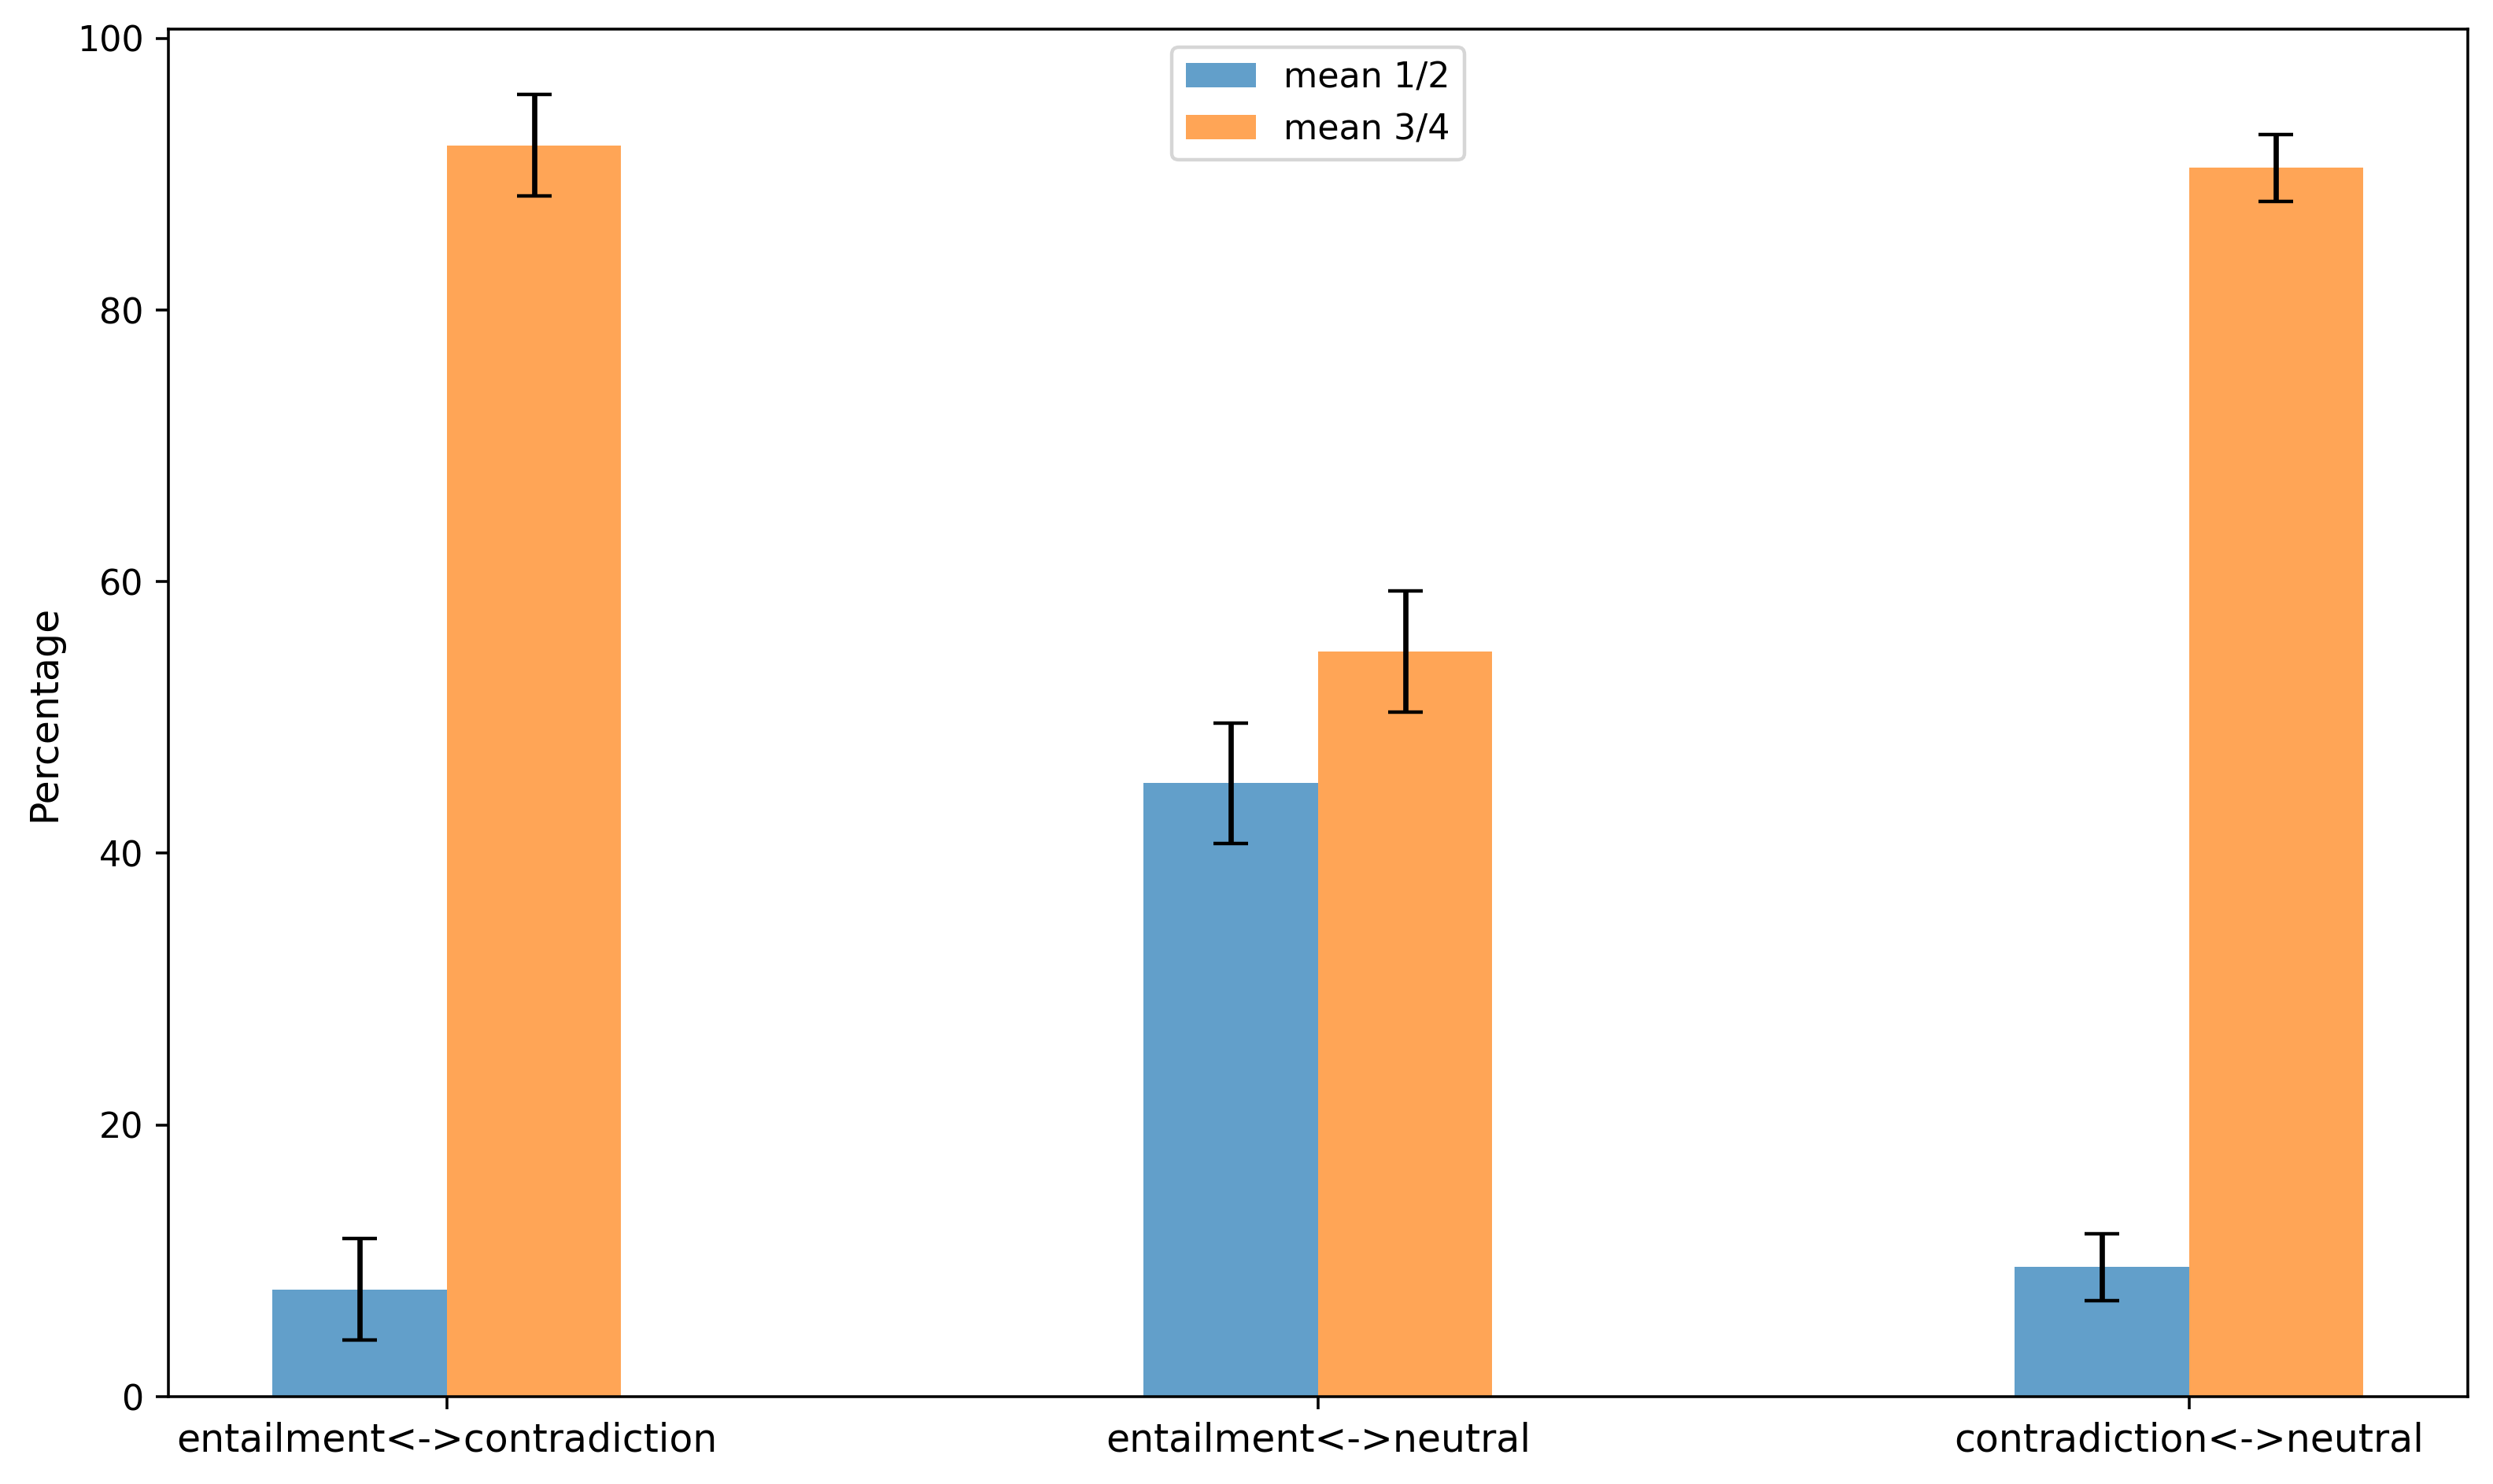

In [ ]:
import matplotlib.pyplot as plt

import numpy as np

means_labels = ['mean 1/2', 'mean 3/4']
# Extract data for plotting
names = df['label1 <-> label2']
means = df[['mean 1/2', 'mean 3/4']]
stds = df[['std 1/2', 'std 3/4']]

# Number of mean columns
num_means = len(means.columns)

fontsize = 11
# Set the positions of the bars on the x-axis
positions = np.arange(len(names))

# Width of each bar
bar_width = 0.20

# Plotting mean values with error bars side by side
plt.figure(figsize=(10, 6), dpi=320)

for i in range(num_means):
    plt.bar(positions + i * bar_width, means.iloc[:, i], 
            yerr=stds.iloc[:, i], 
            width=bar_width,
            #label=f'Mean {i+1}',
            label= means_labels[i],

            alpha=0.7,
            capsize=5)

# Adding labels and title
#plt.xlabel('label1 <--> label2')
plt.ylabel('Percentage', fontsize=fontsize)
#plt.title('Means Values with Standard Deviation')
plt.xticks(positions + (num_means - 1) * bar_width / 2, names, fontsize=fontsize)
plt.legend()

# Show plot
plt.tight_layout()
plt.savefig('../output/nli-src-tgt.pdf', format='pdf')
plt.show()


In [ ]:
num_means

2